In [1]:
import numpy as np
import pickle
from pandas import DataFrame, read_csv
from sklearn import preprocessing
from sklearn import metrics as met
import warnings
import tensorflow as tf
from tensorflow.contrib import rnn
import helperModule as hm
import matplotlib.pyplot as plt
from tensorflow import nn
from matplotlib import gridspec

warnings.filterwarnings("ignore")
%config InlineBackend.figure_format = 'retina'



In [7]:
#########################
############ Hyperparamter
#########################

st_dev = 0.2
learning_rate = 0.001
training_iters = 25000000
batch_size = 128
display_step = 1000
display_testing_step = 4000
dropout_rate = 0.5

n_input = 41 # Number of features
n_steps = 1 # timesteps
n_hidden = 128 # hidden layer num of nodes
n_classes = 5 # KDD99 total classes ( Normal + 4 attack types)


In [3]:
#########################
############ Read in data
#########################

data = pickle.load( open( "kdd99.p", "rb" ) )

x_train = data['x_train']
x_test = data['x_test']
y_train = data['y_train']
y_test = data['y_test']


In [9]:
num_layers = 2

def RNN(x, W, b, n):

    # Prepare data shape to match `rnn` function requirements
    # Current data input shape: (batch_size, n_steps, n_input)
    # Required shape: 'n_steps' tensors list of shape (batch_size, n_input)

    # Unstack to get a list of 'n_steps' tensors of shape (batch_size, n_input)
    x = tf.unstack(x, n_steps, 1)

    # Define a lstm cell with tensorflow
    #with tf.variable_scope('lstm_cell_def'):

        #lstm_cell = tf.contrib.rnn.LSTMCell(n_hidden, state_is_tuple = True)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)  
    stacked_rnn = []
    for i in range(num_layers):
        stacked_rnn.append(tf.contrib.rnn.DropoutWrapper(tf.nn.rnn_cell.LSTMCell(n, state_is_tuple=True), input_keep_prob=keep_prob)) 
    

    lstm_cell = tf.contrib.rnn.MultiRNNCell(stacked_rnn)
        #lstm_cell = tf.contrib.rnn.DropoutWrapper(lstm_cell, input_keep_prob=keep_prob)
                
        
    output, states = tf.nn.static_rnn(lstm_cell, x, dtype=tf.float32)

    # Linear activation, using rnn inner loop last output
    return tf.matmul(output[-1], W['out']) + b['out']





In [14]:
# Launch the graph

learning_rates = np.arange(0.005,0.05,0.0075)
n_hidden = np.arange(64, 256,32)
#n_hidden = 128
training_iters = 12000000


results = {}

for l in learning_rates:
    
    results[l] = []
    
    for n in n_hidden:
    
        tf.reset_default_graph()
        
        x = tf.placeholder("float", [None, n_steps, n_input])
        y = tf.placeholder("float", [None, n_classes])
        keep_prob = tf.placeholder(tf.float32, name='keep_prob')

        # Define weights
        W = {
            'out': tf.Variable(tf.truncated_normal([n, n_classes], stddev=st_dev))
        }

        b = {
        'out': tf.Variable(tf.zeros([n_classes]))
        }
         
        pred = RNN(x, W, b, n)

        # Define loss and optimizer
        cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=pred, labels=y))
        optimizer = tf.train.AdamOptimizer(learning_rate=l).minimize(cost)

        # Evaluate model
        correct_pred = tf.equal(tf.argmax(pred,1), tf.argmax(y,1))
        accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
        init = tf.global_variables_initializer()
        
        with tf.Session() as sess:
            sess.run(init)
            step = 1
            losses = {'train':[], 'validation':[]}
            # Keep training until reach max iterations
            while step * batch_size < training_iters:
                offset = (step * batch_size) % (y_train.shape[0] - batch_size)
                offset_val = (step * batch_size) % (y_test.shape[0] - batch_size)

                # Generate minibatches for training and validating.
                batch_x = x_train[offset:(offset + batch_size), :]
                batch_y = y_train[offset:(offset + batch_size), :]
                batch_val_x = x_test[offset_val:(offset_val + batch_size), :]
                batch_val_y = y_test[offset_val:(offset_val + batch_size), :]

                # Reshape data to feed into RNN
                batch_x = batch_x.reshape((batch_size, n_steps, n_input))
                batch_val_x = batch_val_x.reshape((batch_size, n_steps, n_input))

                # Run optimization op (backprop)
                sess.run(optimizer, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout_rate})
                loss = sess.run(cost, feed_dict={x: batch_x, y: batch_y, keep_prob:dropout_rate})
                loss_test = sess.run(cost, feed_dict={x: batch_val_x, y: batch_val_y, keep_prob:dropout_rate})

                #if step % display_step == 0:

                    #print "Iter " + str(step*batch_size) + ", Minibatch Loss= " + "{:.6f}".format(loss) +  ", Minibatch Val Loss= " + \
                    #      "{:.6f}".format(loss_test)

                losses['train'].append(loss)
                losses['validation'].append(loss_test)
                step += 1

            print("Optimization Finished for learning rate %6f" % l + " and %d hidden units" % n)

            y_pred = sess.run(tf.argmax(pred, 1), feed_dict={x:x_test.reshape((-1, n_steps, n_input)), keep_prob:1.0})
            y_true = np.argmax(y_test,1)
            conf_matrix = met.confusion_matrix(y_true, y_pred)
            conf_bench = hm.getBenchmarkResults()
            metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
    
            results[l].append(metrics)

dump = pickle.dump(results, open( "tuning_results_dropout.p", "wb" ) )

print 'Finished optimization for all parameters!'

Optimization Finished for learning rate 0.005000 and 64 hidden units
Optimization Finished for learning rate 0.005000 and 96 hidden units
Optimization Finished for learning rate 0.005000 and 128 hidden units
Optimization Finished for learning rate 0.005000 and 160 hidden units
Optimization Finished for learning rate 0.005000 and 192 hidden units
Optimization Finished for learning rate 0.005000 and 224 hidden units
Optimization Finished for learning rate 0.012500 and 64 hidden units
Optimization Finished for learning rate 0.012500 and 96 hidden units
Optimization Finished for learning rate 0.012500 and 128 hidden units
Optimization Finished for learning rate 0.012500 and 160 hidden units
Optimization Finished for learning rate 0.012500 and 192 hidden units
Optimization Finished for learning rate 0.012500 and 224 hidden units
Optimization Finished for learning rate 0.020000 and 64 hidden units
Optimization Finished for learning rate 0.020000 and 96 hidden units
Optimization Finished for 

In [20]:
acc = {}
tpr_u2r = {}
tpr_r2l = {}
tpr_dos = {}
tpr_probe = {}
tpr_normal = {}


for key in results.keys():
    print key
    acc[key] = []
    tpr_u2r[key] = []
    tpr_r2l[key] = []
    tpr_dos[key] = []
    tpr_probe[key] = []
    tpr_normal[key] = []
    for entry in results[key]:
        acc[key].append(entry['accuracy_model'])
        tpr_u2r[key].append(entry['tpr_model'][3])
        tpr_r2l[key].append(entry['tpr_model'][4])
        tpr_probe[key].append(entry['tpr_model'][1])
        tpr_normal[key].append(entry['tpr_model'][0])
        tpr_dos[key].append(entry['tpr_model'][2])
        print entry['accuracy_model']


0.05
0.203093602204
0.625237518045
0.67050017844
0.680975085924
0.638577110173
0.636320085908
0.0125
0.685321947471
0.682553716856
0.762600915027
0.686363650978
0.68514833022
0.724485498137
0.0275
0.627205180224
0.30408740021
0.627877143289
0.680656787631
0.771114590601
0.720276887364
0.0425
0.205115921666
0.726308479274
0.628455867459
0.683691874391
0.629198563478
0.205958286848
0.005
0.807262345312
0.811866417601
0.685064736729
0.720794523983
0.744023869157
0.777413038656
0.035
0.646476695099
0.627211610493
0.645865819586
0.680721090316
0.626070237823
0.700844615775
0.02
0.684836462195
0.684752868704
0.683978021342
0.681441280395
0.684579251452
0.786730497799


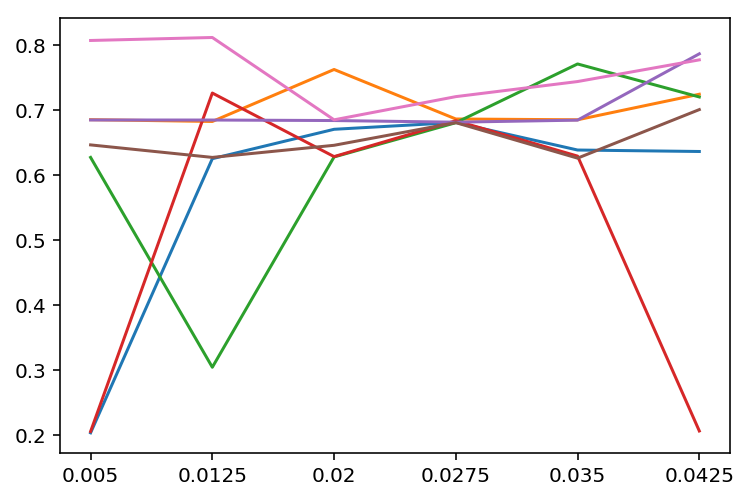

In [22]:


import matplotlib.pyplot as plt
import numpy as np

for key in acc.keys():
    y = acc[key]
    x = np.arange(6)

    plt.plot(x, y)

#plt.ylim([0.02,0.12])
plt.xticks(x, np.arange(0.005,0.05,0.0075))
plt.show()

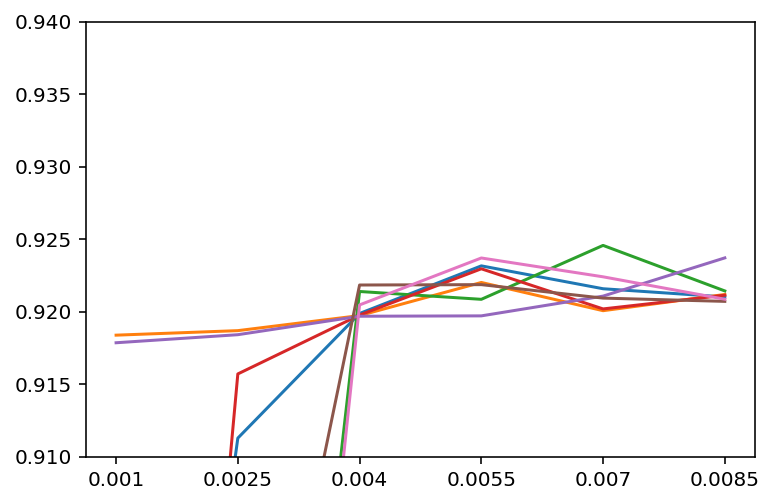

In [86]:
for key in acc.keys():
    y = acc[key]
    x = np.arange(6)

    plt.plot(x, y)

plt.ylim([0.91,0.94])
plt.xticks(x, np.arange(0.001,0.01,0.0015))
plt.show()

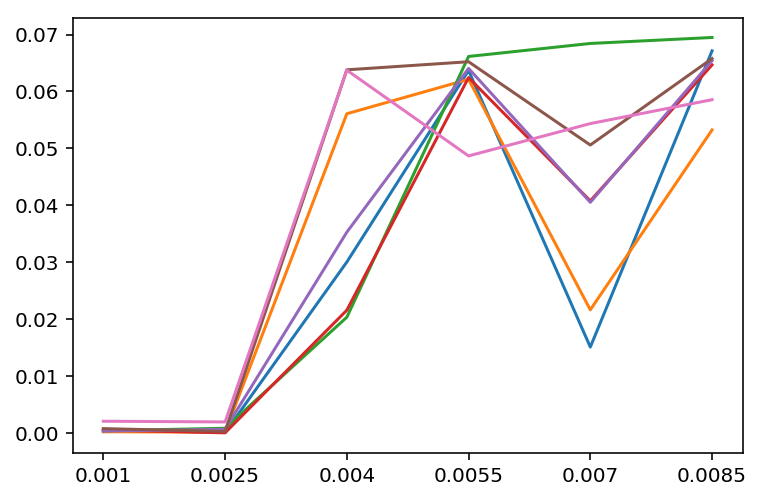

In [74]:
for key in tpr_r2l.keys():
    y = tpr_r2l[key]
    x = np.arange(6)

    plt.plot(x, y)

#plt.ylim([0.81,0.94])
plt.xticks(x, np.arange(0.001,0.01,0.0015))
plt.show()

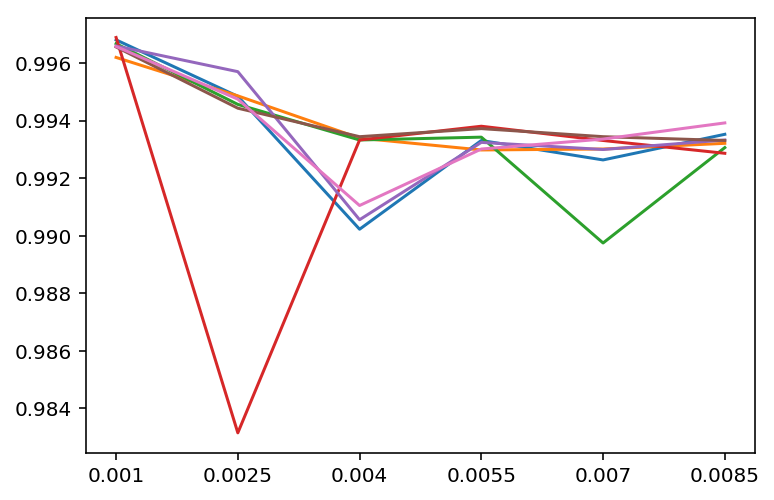

In [84]:
for key in tpr_normal.keys():
    y = tpr_normal[key]
    x = np.arange(6)

    plt.plot(x, y)

#plt.ylim([0.81,0.94])
plt.xticks(x, np.arange(0.001,0.01,0.0015))
plt.legend()
plt.show()

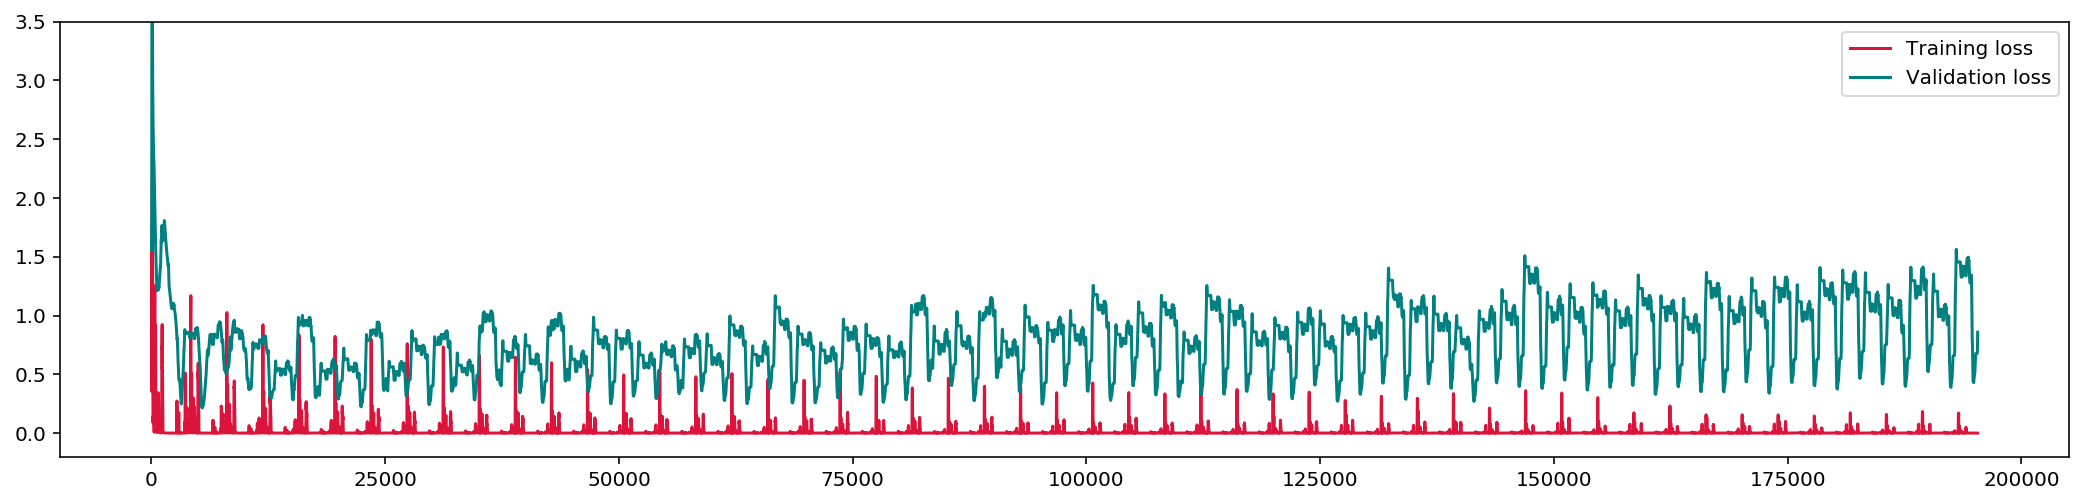

In [30]:

smoothed_loss = hm.running_mean(losses['train'], 50)
smoothed_loss_train = hm.running_mean(losses['validation'], 1800)

fig = plt.figure(figsize=(18,4))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:2])

ax1.plot(smoothed_loss, label='Training loss', color='crimson')
ax1.plot(smoothed_loss_train, label='Validation loss', color='teal')
ax1.legend()
plt.ylim([-0.2,3.5])
plt.show()

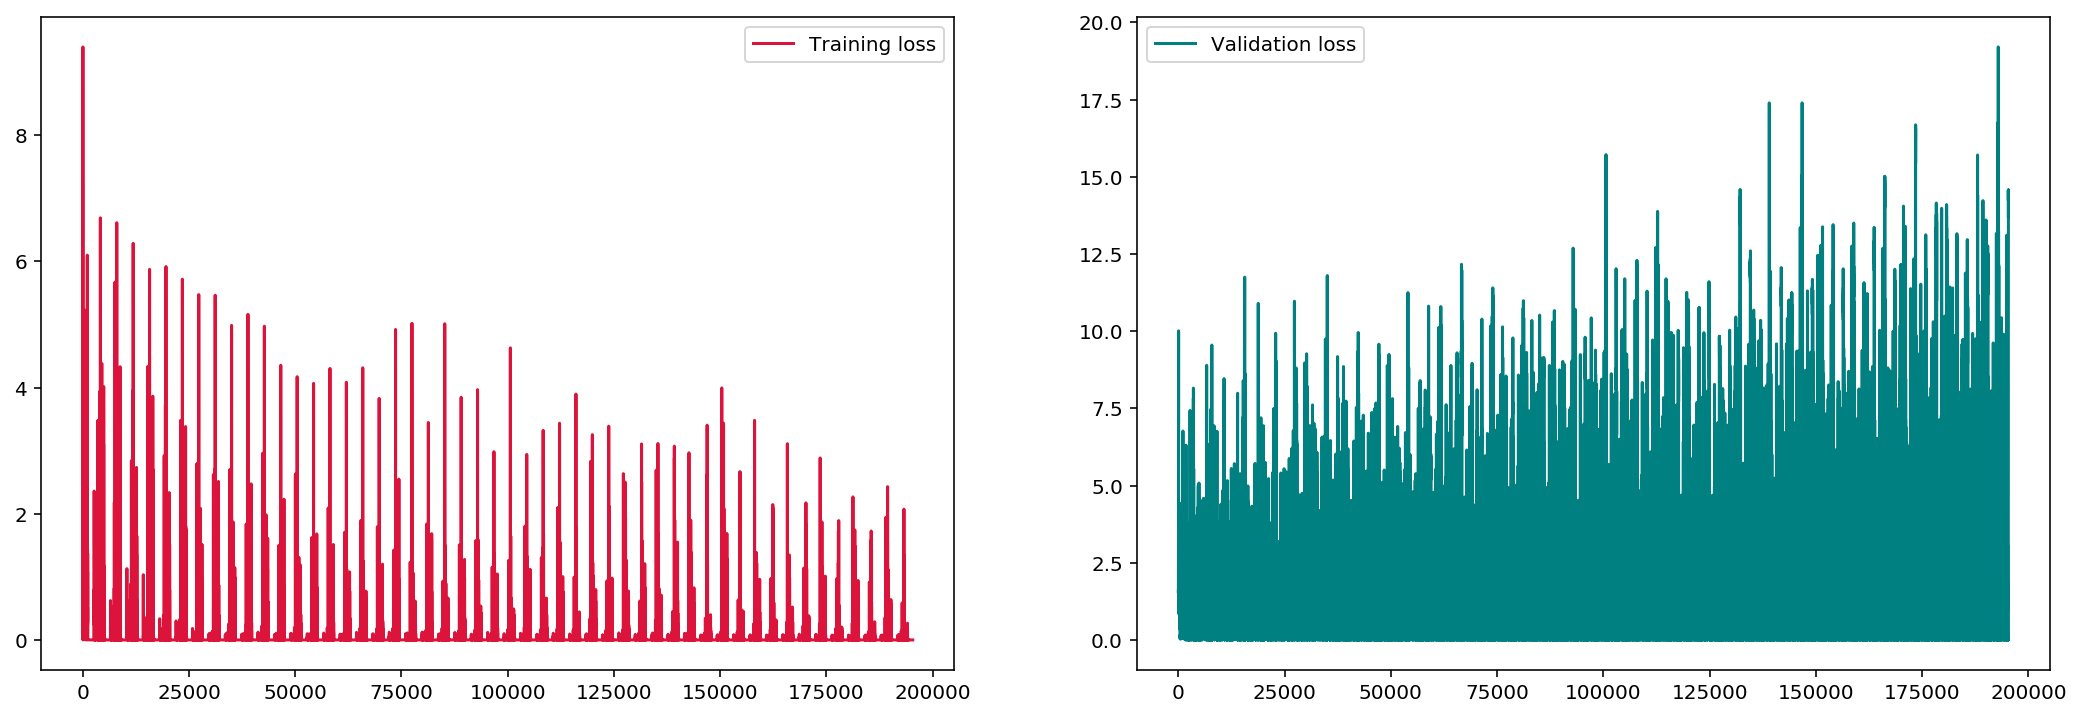

In [31]:
fig = plt.figure(figsize=(18,6))
gs  = gridspec.GridSpec(1, 2, height_ratios=[1],width_ratios=[0.5,0.5])
ax1 = plt.subplot(gs[0, 0:1])
ax2 = plt.subplot(gs[0, 1:])

ax1.plot(losses['train'], label='Training loss', color='crimson')
ax2.plot(losses['validation'], label='Validation loss', color='teal')
ax1.legend()
ax2.legend()

plt.show()

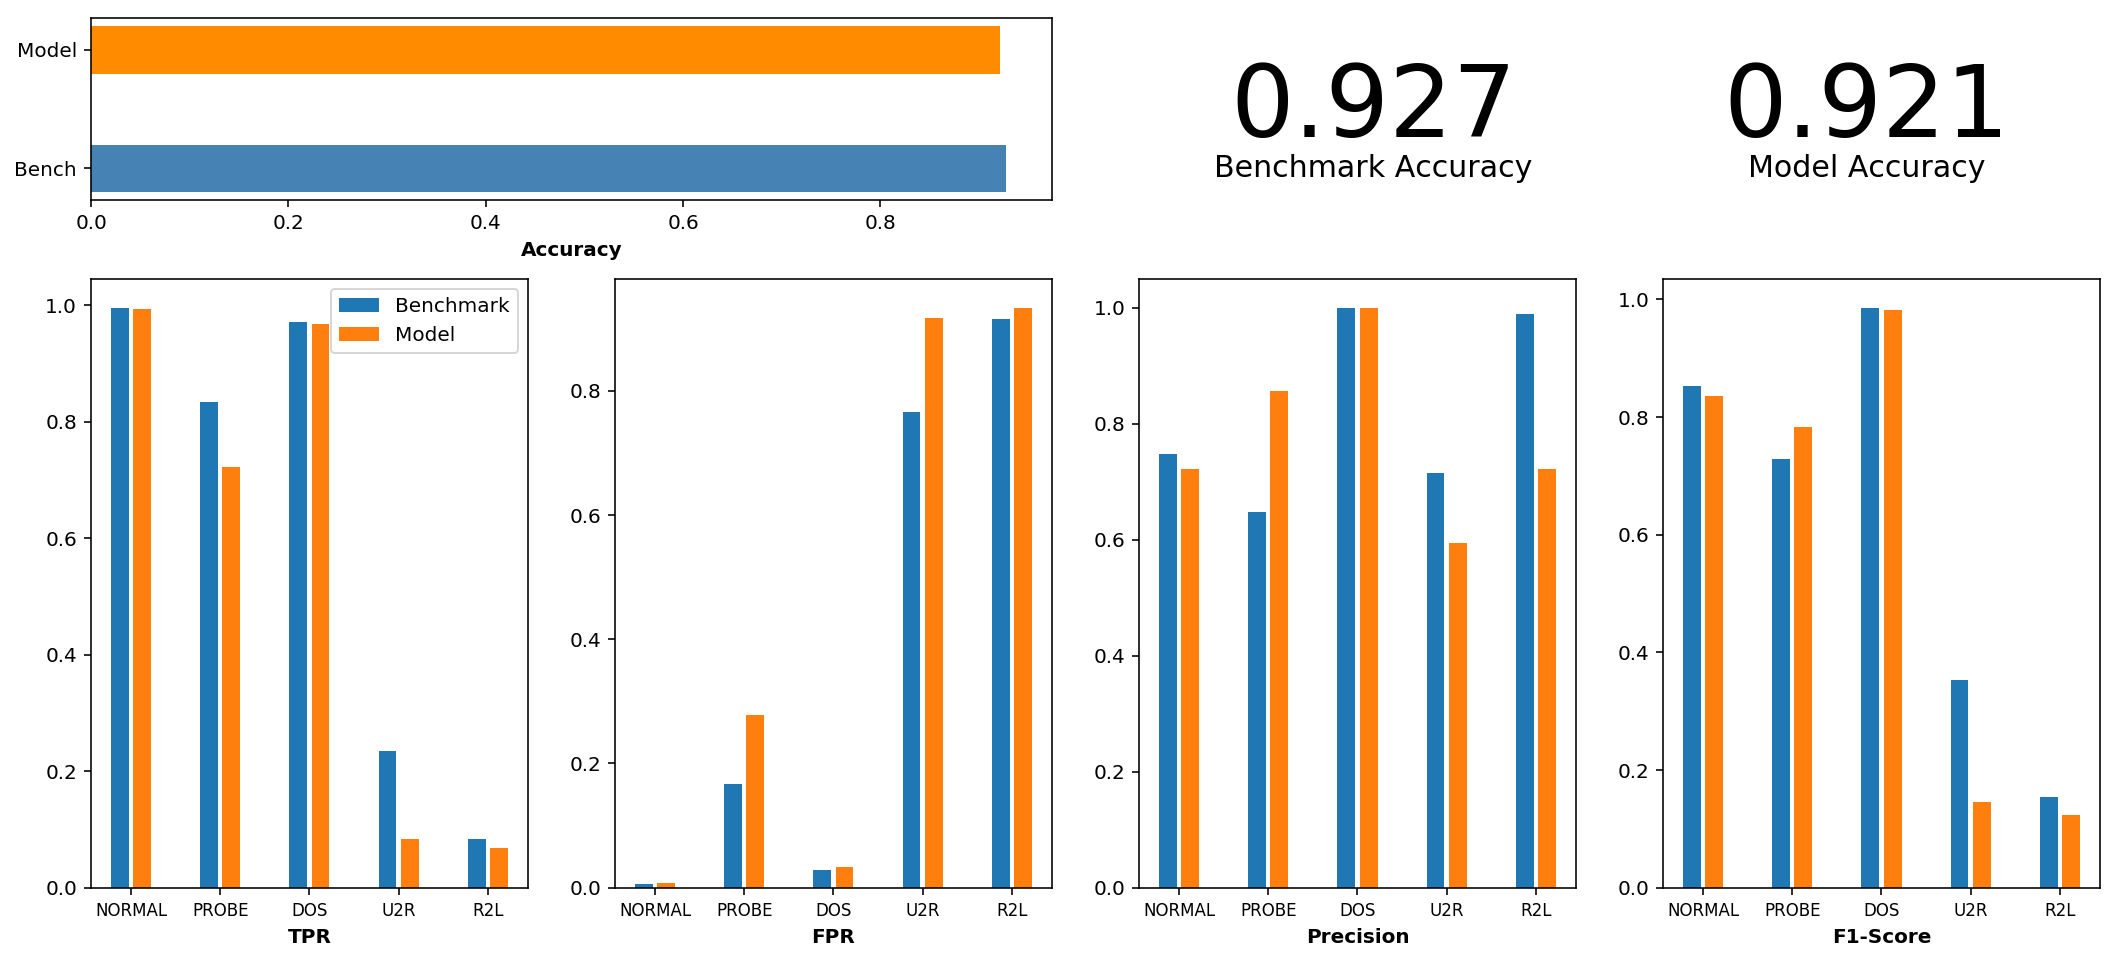

In [32]:
conf_bench = hm.getBenchmarkResults()
metrics = hm.computePerformanceMetrics(conf_bench, conf_matrix)
hm.plotMetrics(metrics)

